In [ ]:
# Data processing
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import pickle

# Path configuration for custom module imports  
# -----------------------------------------------------------------------
import sys  
sys.path.append('../')  # Adds the parent directory to the path for custom module imports  

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings  
warnings.filterwarnings("ignore") 

# Custom functions and classes
# -----------------------------------------------------------------------
from src.support_regression import RegressionModels, FullRegressor


### Data loading

In [4]:
df = pd.read_csv('../data/output/api_rent_madrid_preprocessed.csv', index_col=0).reset_index(drop=True)
df.head()

,price,size,exterior,rooms,bathrooms,distance,municipality,province,hasLift,numPhotos,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,floor
0,550.0,8.442463,False,4.410093,3,1.048670,657.095509,579.687729,661.431099,1.152172,1.0,0.0,0.0,0.0,0.0,0.0,13.0
1,750.0,-0.221149,True,-0.712507,1,-0.896578,705.594108,693.233618,677.631111,-1.021827,0.0,0.0,0.0,1.0,0.0,0.0,6.0
2,750.0,0.057424,True,0.312013,1,-0.360972,685.520603,693.233618,670.210811,-0.090113,0.0,0.0,0.0,1.0,0.0,0.0,2.0
3,400.0,-0.026148,True,0.312013,2,1.926351,637.579238,693.233618,670.210811,0.634554,0.0,0.0,0.0,0.0,1.0,0.0,5.0
4,450.0,0.586712,False,0.312013,1,1.464429,644.084662,579.687729,677.631111,0.013411,0.0,0.0,0.0,1.0,0.0,0.0,5.0


---

### Model execution

In this notebook, we will run a gradient boosting model for our data.

In [6]:
params_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': range(3, 10),
    'min_samples_split': range(6, 16),
    'min_samples_leaf': range(2, 6)
}

In [8]:
gb_model = RegressionModels(df, 'price', frac=0.8, seed=2)

results = gb_model.model_fit("gradient_boosting", params_gb)
gb_model.get_results()
gb_model.get_metrics("gradient_boosting").round(2)

,R2,MAE,RMSE
train,0.78,30.65,38.31
test,0.79,32.44,42.11


The performance is very similar to that of the random forest.

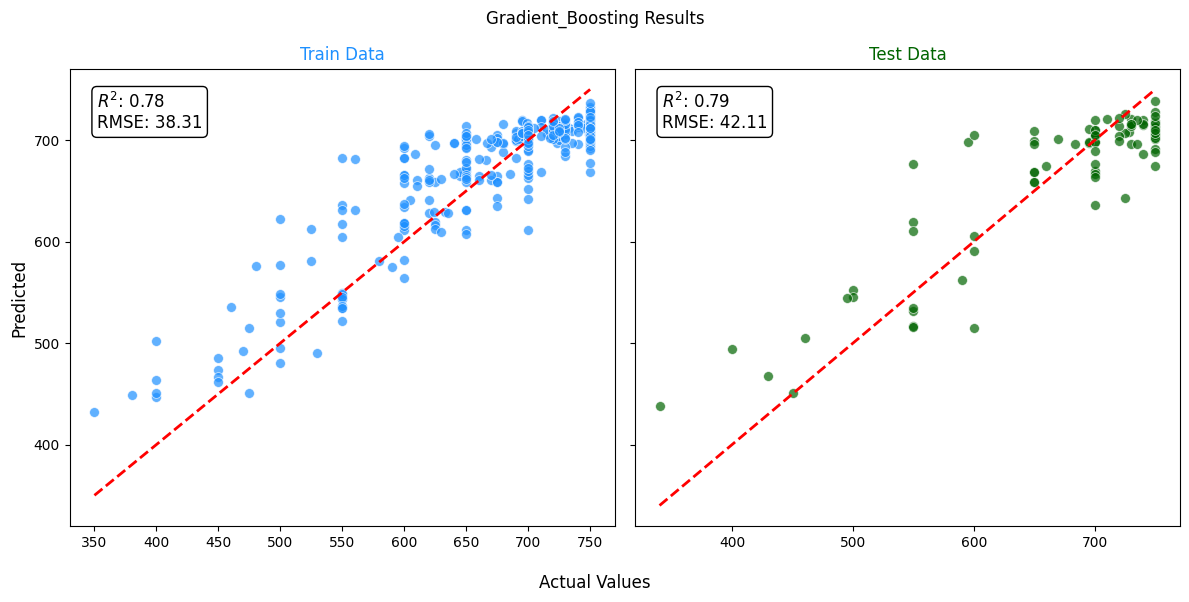

In [11]:
gb_model.plot_actual_vs_prediction('gradient_boosting')

The prediction shows reasonably good results across all ranges, similar to the random forest model.

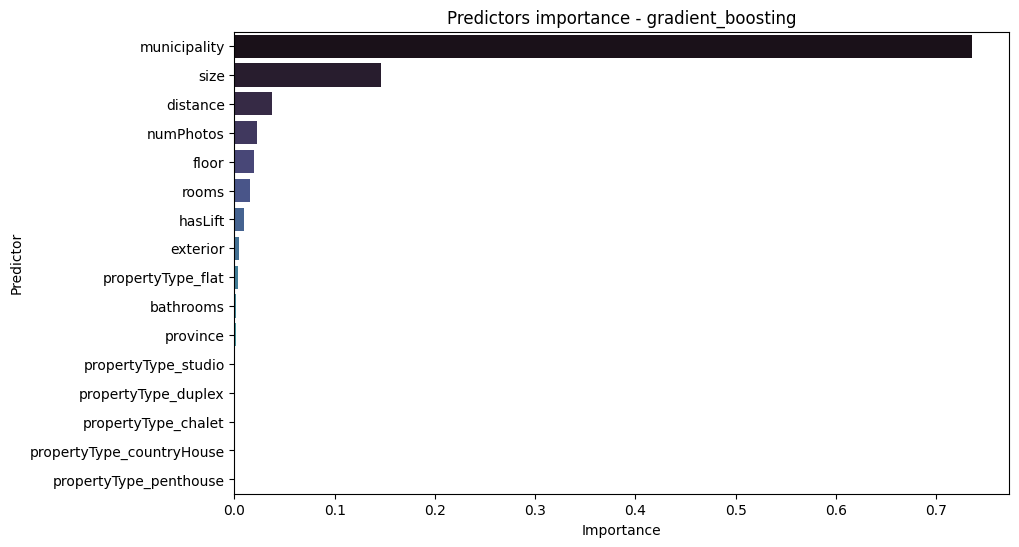

,Predictor,Importance
5,municipality,0.736136
0,size,0.146282
4,distance,0.037957
8,numPhotos,0.022097
15,floor,0.019901
2,rooms,0.015841
7,hasLift,0.009556
1,exterior,0.004226
12,propertyType_flat,0.003978
3,bathrooms,0.001278


In [12]:
gb_model.predictors_importance('gradient_boosting')

Top3 important variables are the same as in decision tree model. Let's try again and dropping not important columns

In [13]:
df2 = df.copy()

In [14]:
df2.drop(columns=['propertyType_penthouse', 'propertyType_countryHouse', 'propertyType_chalet'], inplace=True)

In [17]:
gb_model2 = RegressionModels(df2, 'price', frac=0.8, seed=2)

results = gb_model2.model_fit("gradient_boosting", params_gb)
gb_model2.get_results()
gb_model2.get_metrics("gradient_boosting").round(2)

,R2,MAE,RMSE
train,0.78,30.65,38.31
test,0.79,32.48,42.17


We get identical results.

### Full Training

Finally, we train the model with the complete dataset.

In [34]:
gb_model_final = FullRegressor(df, 'price')

results = gb_model_final.model_fit("gradient_boosting", params_gb)
gb_model_final.get_results()
gb_model_final.get_metrics("gradient_boosting").round(2)

,R2,MAE,RMSE
train,0.81,28.08,36.37


### Model dump

In [35]:
with open('../models/gb_model.pkl', 'wb') as f:
    pickle.dump(gb_model_final, f)